Installing all the necessary libraries

In [ ]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Import all the necessary libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import string

from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Define some constants to be used in the feature extraction

In [ ]:
PARAMS = {
    "best_k": 100,
    "char_ngram_size": 1,
    "vocab_gender_pronouns" : ["he","she"],
    "max_df" : 0.8,
    "min_df" : 2,
    "max_depth" : 7,
    "n_estimators" : 100
}

Load the dataset (training, development and test)

In [ ]:
# Load the datasets (train, dev and test)
def load_dataset(dir_path):
    df_train = pd.read_csv(f"{dir_path}pan2324_train_data.csv")
    df_dev = pd.read_csv(f"{dir_path}pan2324_dev_data.csv")
    df_test = pd.read_csv(f"{dir_path}pan2324_test_data.csv")
    return df_train, df_dev, df_test
# change the dir path accordingly
dir_path = "Assignment-4-TxMM/"
df_train, df_dev, df_test = load_dataset(dir_path)
x_train, y_train = df_train['text'],df_train['author']
x_dev, y_dev = df_dev['text'],df_dev['author']
x_test, y_test = df_test['text'],df_test['author']
df_train

,Unnamed: 0,text,author
0,198,Prompt 27: Misguided They arrived in Konoha in...,560480
1,3621,"She calmly replied, he expected her to come an...",6234395
2,654,"Within seconds, I found my heart pounding near...",806976
3,471,The glow was beautiful and it was specifically...,1220273
4,1937,"As he approached the barn, he could hear the s...",967934
...,...,...,...
2848,1130,"As she got into the elevator, she saw a girl c...",3439302
2849,1294,"Please call me that."" The princess said in a s...",2750536
2850,860,"He hadn""t noticed when he""d been left alone wi...",1497577
2851,3507,Puck growled and slammed his fist into a hand ...,1112924


# Feature Extraction

Extract ellipsis count (triple dots '...') 

In [ ]:
### EXTRACT ELLIPSIS (...) COUNT
def get_ellipsis_counts(text_data):
    ellipsis_count = text_data.map(lambda x: x.count('...'))
    return np.array(ellipsis_count).reshape(-1, 1)

Extract sentence counts (Syntactical feature)

In [ ]:
### EXTRACT SENTENCE COUNTS
def get_sentence_counts(text_data):
    sent_counts = text_data.map(lambda x: len(sent_tokenize(x)))
    return np.array(sent_counts).reshape(-1, 1)

Extract POS tag counts (Syntactical feature)

In [ ]:
## EXTRACT POS TAG COUNTS
def get_pos_tag_counts(texts):
    pos_tag_counts = []
    for text in texts:
        tokens = word_tokenize(text)
        pos_tags = [tag[1] for tag in nltk.pos_tag(tokens)]
        pos_tag_counts.append(nltk.Counter(pos_tags))
    pos_occurence_df = pd.DataFrame(pos_tag_counts).replace(np.nan,0)  # Replacing the nan values with 0
    return pos_occurence_df.drop('SYM', axis=1, errors='ignore')

Extract average word length (Lexical feature)

In [ ]:
# EXTRACT AVERAGE WORD LENGTH
def get_avg_word_length(texts):
    avg_word_lengths = [
        sum(len(word) for word in word_tokenize(text)) / len(word_tokenize(text)) if len(word_tokenize(text)) > 0 else 0
        for text in texts]
    return np.array(avg_word_lengths).reshape(-1, 1)


Features we use: character frequencies, POS tag counts, N-grams (tf-idf), sentence length (# of words), function word frequencies(stopwords), gender pronouns counts, average word length, ellipsis count(...)

In [ ]:
feature_groups = [
    # Lexical features
    ('tfidf_text', TfidfVectorizer(analyzer= "word", 
                                    ngram_range=(PARAMS['char_ngram_size'],PARAMS['char_ngram_size']), 
                                    max_df=PARAMS["max_df"], 
                                    min_df = PARAMS["min_df"]), 'text'),
    # Gender pronouns He She
    ('gender_pronouns', CountVectorizer(vocabulary=PARAMS['vocab_gender_pronouns']), 'text'),
    # Stopword counts
    ('stopwords_counts', TfidfVectorizer(stop_words='english'), 'text'),
    # Char features
    ('char_count', CountVectorizer(lowercase=False, ngram_range=(PARAMS['char_ngram_size'],PARAMS['char_ngram_size']), analyzer='char'), 'text'),
    # Ellipsis counts
    ('ellipsis_counts', FunctionTransformer(get_ellipsis_counts), 'text'),
    # Sentence counts
    ('sentence_counts', FunctionTransformer(get_sentence_counts), 'text'),
    # Average word length
    ('avg_word_length', FunctionTransformer(get_avg_word_length), 'text'),
    # Syntactical features 
    # POS tag counts
    ('pos_tag_counts', FunctionTransformer(get_pos_tag_counts), 'text'),            
]

Build the Pipeline.

In [ ]:
pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(
        transformers=feature_groups,
        remainder='passthrough'
    )),
    # ('feature_selection', SelectKBest(score_func=chi2, k=PARAMS['best_k'])),
    ('classifier', RandomForestClassifier(max_depth=PARAMS['max_depth'],n_estimators=PARAMS['n_estimators'], random_state=42))
    #('classifier', MultinomialNB()),
    #('classifier', SVC())
])

Train on the train dataset

In [ ]:
pipeline.fit(df_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf_text',
                                                  TfidfVectorizer(max_df=0.8,
                                                                  min_df=2),
                                                  'text'),
                                                 ('gender_pronouns',
                                                  CountVectorizer(vocabulary=['he',
                                                                              'she']),
                                                  'text'),
                                                 ('stopwords_counts',
                                                  TfidfVectorizer(stop_words='english'),
                                                  'text'),
                                                 ('char_count',
                                                  CountVectorizer(analyzer='char',
                                                                  lowercase=False),
                                                  'text'...
                                                 ('sentence_counts',
                                                  FunctionTransformer(func=<function get_sentence_counts at 0x7f29f2efc820>),
                                                  'text'),
                                                 ('avg_word_length',
                                                  FunctionTransformer(func=<function get_avg_word_length at 0x7f29f2efc700>),
                                                  'text'),
                                                 ('pos_tag_counts',
                                                  FunctionTransformer(func=<function get_pos_tag_counts at 0x7f29f2efcee0>),
                                                  'text')])),
                ('classifier',
                 RandomForestClassifier(max_depth=7, random_state=42))])

Predict on all three datasets and print the results

In [ ]:
def get_results(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    print(f"Accuracy: {accuracy}")
    f1 = f1_score(y_true,y_pred, average='weighted')
    print(f"F1-Score: {f1}")
    results = classification_report(y_true,y_pred)
    print(results)
    conf_matrix = pd.DataFrame(confusion_matrix(y_true,y_pred))
    sns.heatmap(conf_matrix, cmap='Blues')
    return f1

Accuracy: 0.963547143357869
F1-Score: 0.9631591304361241
              precision    recall  f1-score   support

       29783       1.00      1.00      1.00       148
      240213       0.99      1.00      1.00       148
      512464       0.97      0.95      0.96       132
      560480       0.96      1.00      0.98       149
      583064       0.99      0.99      0.99       143
      583994       1.00      0.98      0.99       133
      748687       0.93      1.00      0.96       174
      806976       0.88      0.97      0.93       155
      870118       0.83      0.98      0.90       154
      910821       0.98      1.00      0.99       145
      967934       0.97      1.00      0.98       146
     1112924       0.98      0.94      0.96       139
     1220273       0.93      1.00      0.97       139
     1276465       0.99      0.97      0.98       145
     1497577       1.00      0.87      0.93       128
     2750536       0.99      0.97      0.98       138
     2855986       1.00 

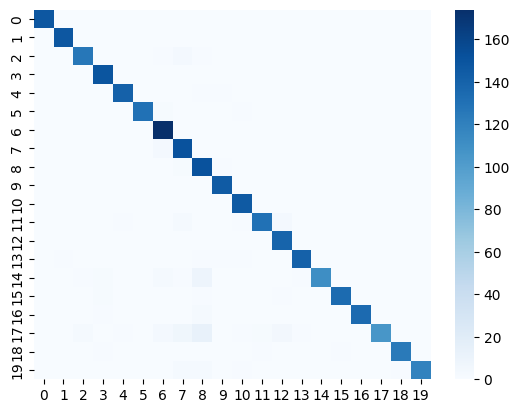

In [ ]:
y_pred_train = pipeline.predict(df_train)
f1 = get_results(y_train,y_pred_train)

Accuracy: 0.9163179916317992
F1-Score: 0.9085440054478331
              precision    recall  f1-score   support

       29783       1.00      1.00      1.00        10
      240213       0.93      0.93      0.93        15
      512464       0.82      1.00      0.90         9
      560480       0.93      0.93      0.93        14
      583064       0.92      1.00      0.96        11
      583994       1.00      0.94      0.97        17
      748687       0.74      1.00      0.85        17
      806976       0.87      1.00      0.93        13
      870118       0.88      1.00      0.93         7
      910821       1.00      1.00      1.00        16
      967934       0.91      1.00      0.95        10
     1112924       0.90      1.00      0.95         9
     1220273       0.83      0.91      0.87        11
     1276465       0.92      0.92      0.92        13
     1497577       1.00      0.67      0.80        15
     2750536       0.90      1.00      0.95         9
     2855986       1.00

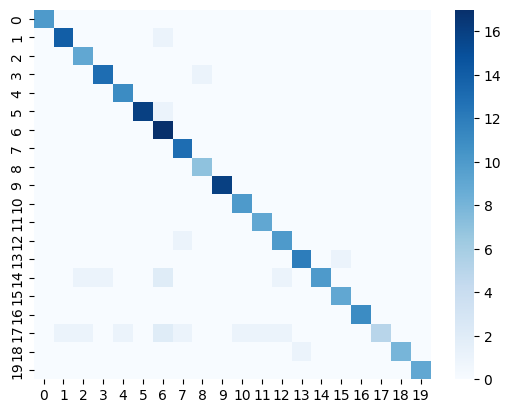

In [ ]:
y_pred_dev = pipeline.predict(df_dev)
f1 = get_results(y_dev,y_pred_dev)

Accuracy: 0.8786610878661087
F1-Score: 0.8805414276373266
              precision    recall  f1-score   support

       29783       1.00      1.00      1.00        14
      240213       0.45      1.00      0.62         5
      512464       0.94      0.88      0.91        17
      560480       0.94      1.00      0.97        16
      583064       1.00      0.83      0.91        12
      583994       1.00      0.88      0.93         8
      748687       0.67      1.00      0.80        12
      806976       0.82      0.90      0.86        10
      870118       0.86      0.86      0.86         7
      910821       0.82      1.00      0.90        14
      967934       0.80      0.89      0.84         9
     1112924       1.00      0.87      0.93        15
     1220273       0.71      0.91      0.80        11
     1276465       0.83      1.00      0.91        15
     1497577       1.00      0.62      0.76        13
     2750536       1.00      0.85      0.92        13
     2855986       1.00

0.8805414276373266

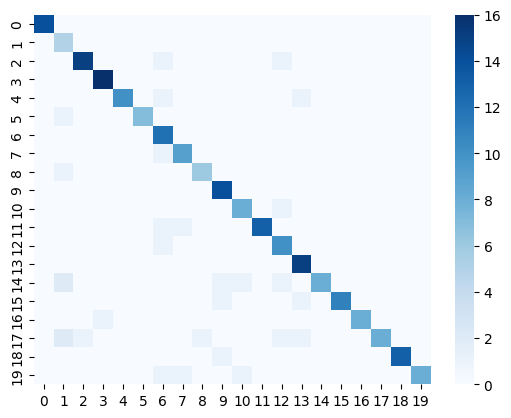

In [ ]:
y_pred_test = pipeline.predict(df_test)
get_results(y_test,y_pred_test)

## Ablation Analysis

Starting with the baseline f1 score and removing one group of features in every iteration

It may take some time(~30 minutes)

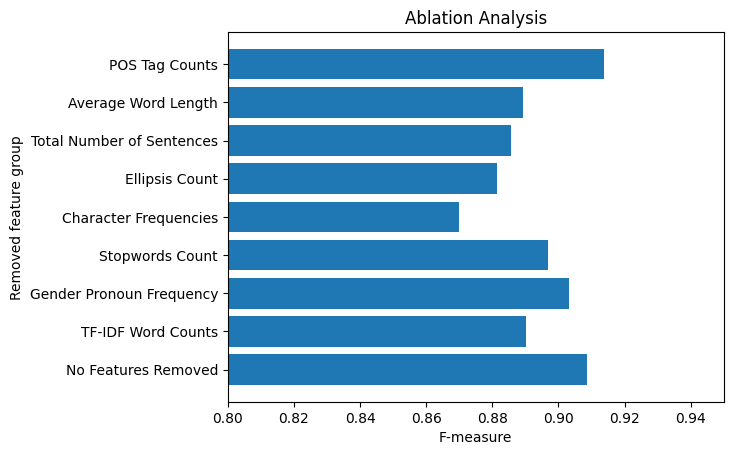

In [ ]:
group_name_labels = {
    "pos_tag_counts": "POS Tag Counts",
    "avg_word_length": "Average Word Length",
    "sentence_counts": "Total Number of Sentences",
    "ellipsis_counts": "Ellipsis Count",
    "char_count": "Character Frequencies",
    "stopwords_counts": "Stopwords Count",
    "gender_pronouns": "Gender Pronoun Frequency",
    "tfidf_text": "TF-IDF Word Counts",
    "None": "No Features Removed"
}

# Add the base score
f_scores = [f1]
feature_names = ['None']

for group_name, transformer, column in feature_groups:
    pipeline_clone = clone(pipeline)
    
    # Remove the selected group name
    pipeline_clone.named_steps['preprocessor'].transformers = [
        (name, transformer, column) for name, transformer, column in feature_groups if name != group_name
    ]

    #fit on the train dataset
    pipeline_clone.fit(df_train, y_train)
    y_pred = pipeline_clone.predict(df_dev)
    
    feature_names.append(group_name)
    f_scores.append(f1_score(y_dev, y_pred, average='weighted'))

plt.barh([group_name_labels[f] for f in feature_names],f_scores)
plt.xlim(0.8, 0.95)
plt.xlabel('F-measure')
plt.ylabel('Removed feature group')
plt.title('Ablation Analysis')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b8c059da-9c99-4010-a58a-2ae6483130f7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>